## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 0.1~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-5}~\varepsilon / k_B$;
   - Скорости охлаждения: $v_1 = 0.02~\varepsilon / k_B\tau; v_2 = 0.001~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2500$ шагов;
   - Число ансамблей $N=1000$;
   - Подсчёт состоял из $2N+499$ шагов: $500$ на уравновешивание системы при фиксированной температуре и $2N-1$ на усреднение по ансамблям (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.postprocessing import PostProcessor, RegressionRDF

#### Настройки рисунков

In [2]:
FIGSIZE = (7, 7)
FONTSIZE = 14

plt.style.use('seaborn')
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE
plt.rcParams['legend.fontsize'] = FONTSIZE 
plt.rcParams['axes.titlesize'] = FONTSIZE
plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['font.size'] = FONTSIZE

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)


#### Путь к файлам с данными

In [3]:
CURRENT_DATA_NORMAL = '2021-06-12_cooling_normal'
CURRENT_DATA_SLOW = '2021-06-12_cooling_slow'
PLOT_FILENAME_POSTFIX_NORMAL = 'cooling_normal'
PLOT_FILENAME_POSTFIX_SLOW = 'cooling_slow'

In [4]:
PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_CURRENT_DATA_SLOW = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_DATA_SLOW

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-06-12_cooling_slow'

In [5]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_PLOTS

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\plots\\2021-06-12_cooling_slow'

#### Пользовательские функции

In [6]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры системы, при которых были подчитаны функции радиального распределения, среднеквадратичные смещения и т.д.

In [8]:
threshold = 0.25

setups_normal, setups_slow = [], []
for filename in os.listdir(PATH_TO_CURRENT_DATA_NORMAL)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,

        }
        if setup['temperature'] > threshold:
            setups_normal.append(setup)

for filename in os.listdir(PATH_TO_CURRENT_DATA_SLOW)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,

        }
        if setup['temperature'] > threshold:
            setups_slow.append(setup)
        
setups_normal

[{'temperature': 0.99952, 'pressure': -2.18985, 'heating_velocity': 0.02},
 {'temperature': 0.74903, 'pressure': 0.28896, 'heating_velocity': 0.02},
 {'temperature': 0.49971, 'pressure': -2.56458, 'heating_velocity': 0.02},
 {'temperature': 0.49929, 'pressure': -0.35487, 'heating_velocity': 0.02},
 {'temperature': 0.29979, 'pressure': -2.71447, 'heating_velocity': 0.02}]

#### Температуры, для которых функция радиального распределения предсказывается

In [9]:
test_temperatures = [setup['temperature'] for setup in setups_normal]
test_temperatures

[0.99952, 0.74903, 0.49971, 0.49929, 0.29979]

#### Инициализация объекта для обработки данных и вывод таблицы значений функции радиального распределения

In [10]:
pp_normal = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA_NORMAL, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX_NORMAL, 
    setups=setups_normal,
)
pp_slow = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA_SLOW, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX_SLOW, 
    setups=setups_slow,
)
pp_slow.rdf.data

,radius,setup_0,setup_1,setup_2,setup_3,setup_4,setup_5,setup_6,setup_7,setup_8,...,setup_29,setup_30,setup_31,setup_32,setup_33,setup_34,setup_35,setup_36,setup_37,setup_38
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,6.08,1.000569,1.003953,1.001820,1.002352,1.006180,1.003339,1.002689,1.002552,1.004018,...,0.963268,0.963679,0.962937,0.958630,0.964659,0.984181,0.957964,0.876962,0.836915,0.830279
608,6.09,1.000721,1.004857,1.003524,1.001274,1.004060,1.004222,1.004005,1.002414,1.003125,...,0.961804,0.962245,0.960175,0.958493,0.965243,0.984333,0.957233,0.873615,0.830924,0.823593
609,6.10,0.999524,1.004392,1.002911,1.001973,1.003346,1.004989,1.003450,1.002458,1.005793,...,0.963013,0.962665,0.960344,0.960664,0.961900,0.984272,0.959026,0.876363,0.823148,0.823287
610,6.11,1.000953,1.004796,1.001957,1.004307,1.003266,1.004559,1.004169,1.002582,1.005550,...,0.962563,0.961257,0.959261,0.960868,0.961471,0.983301,0.961080,0.877985,0.817742,0.821531


#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

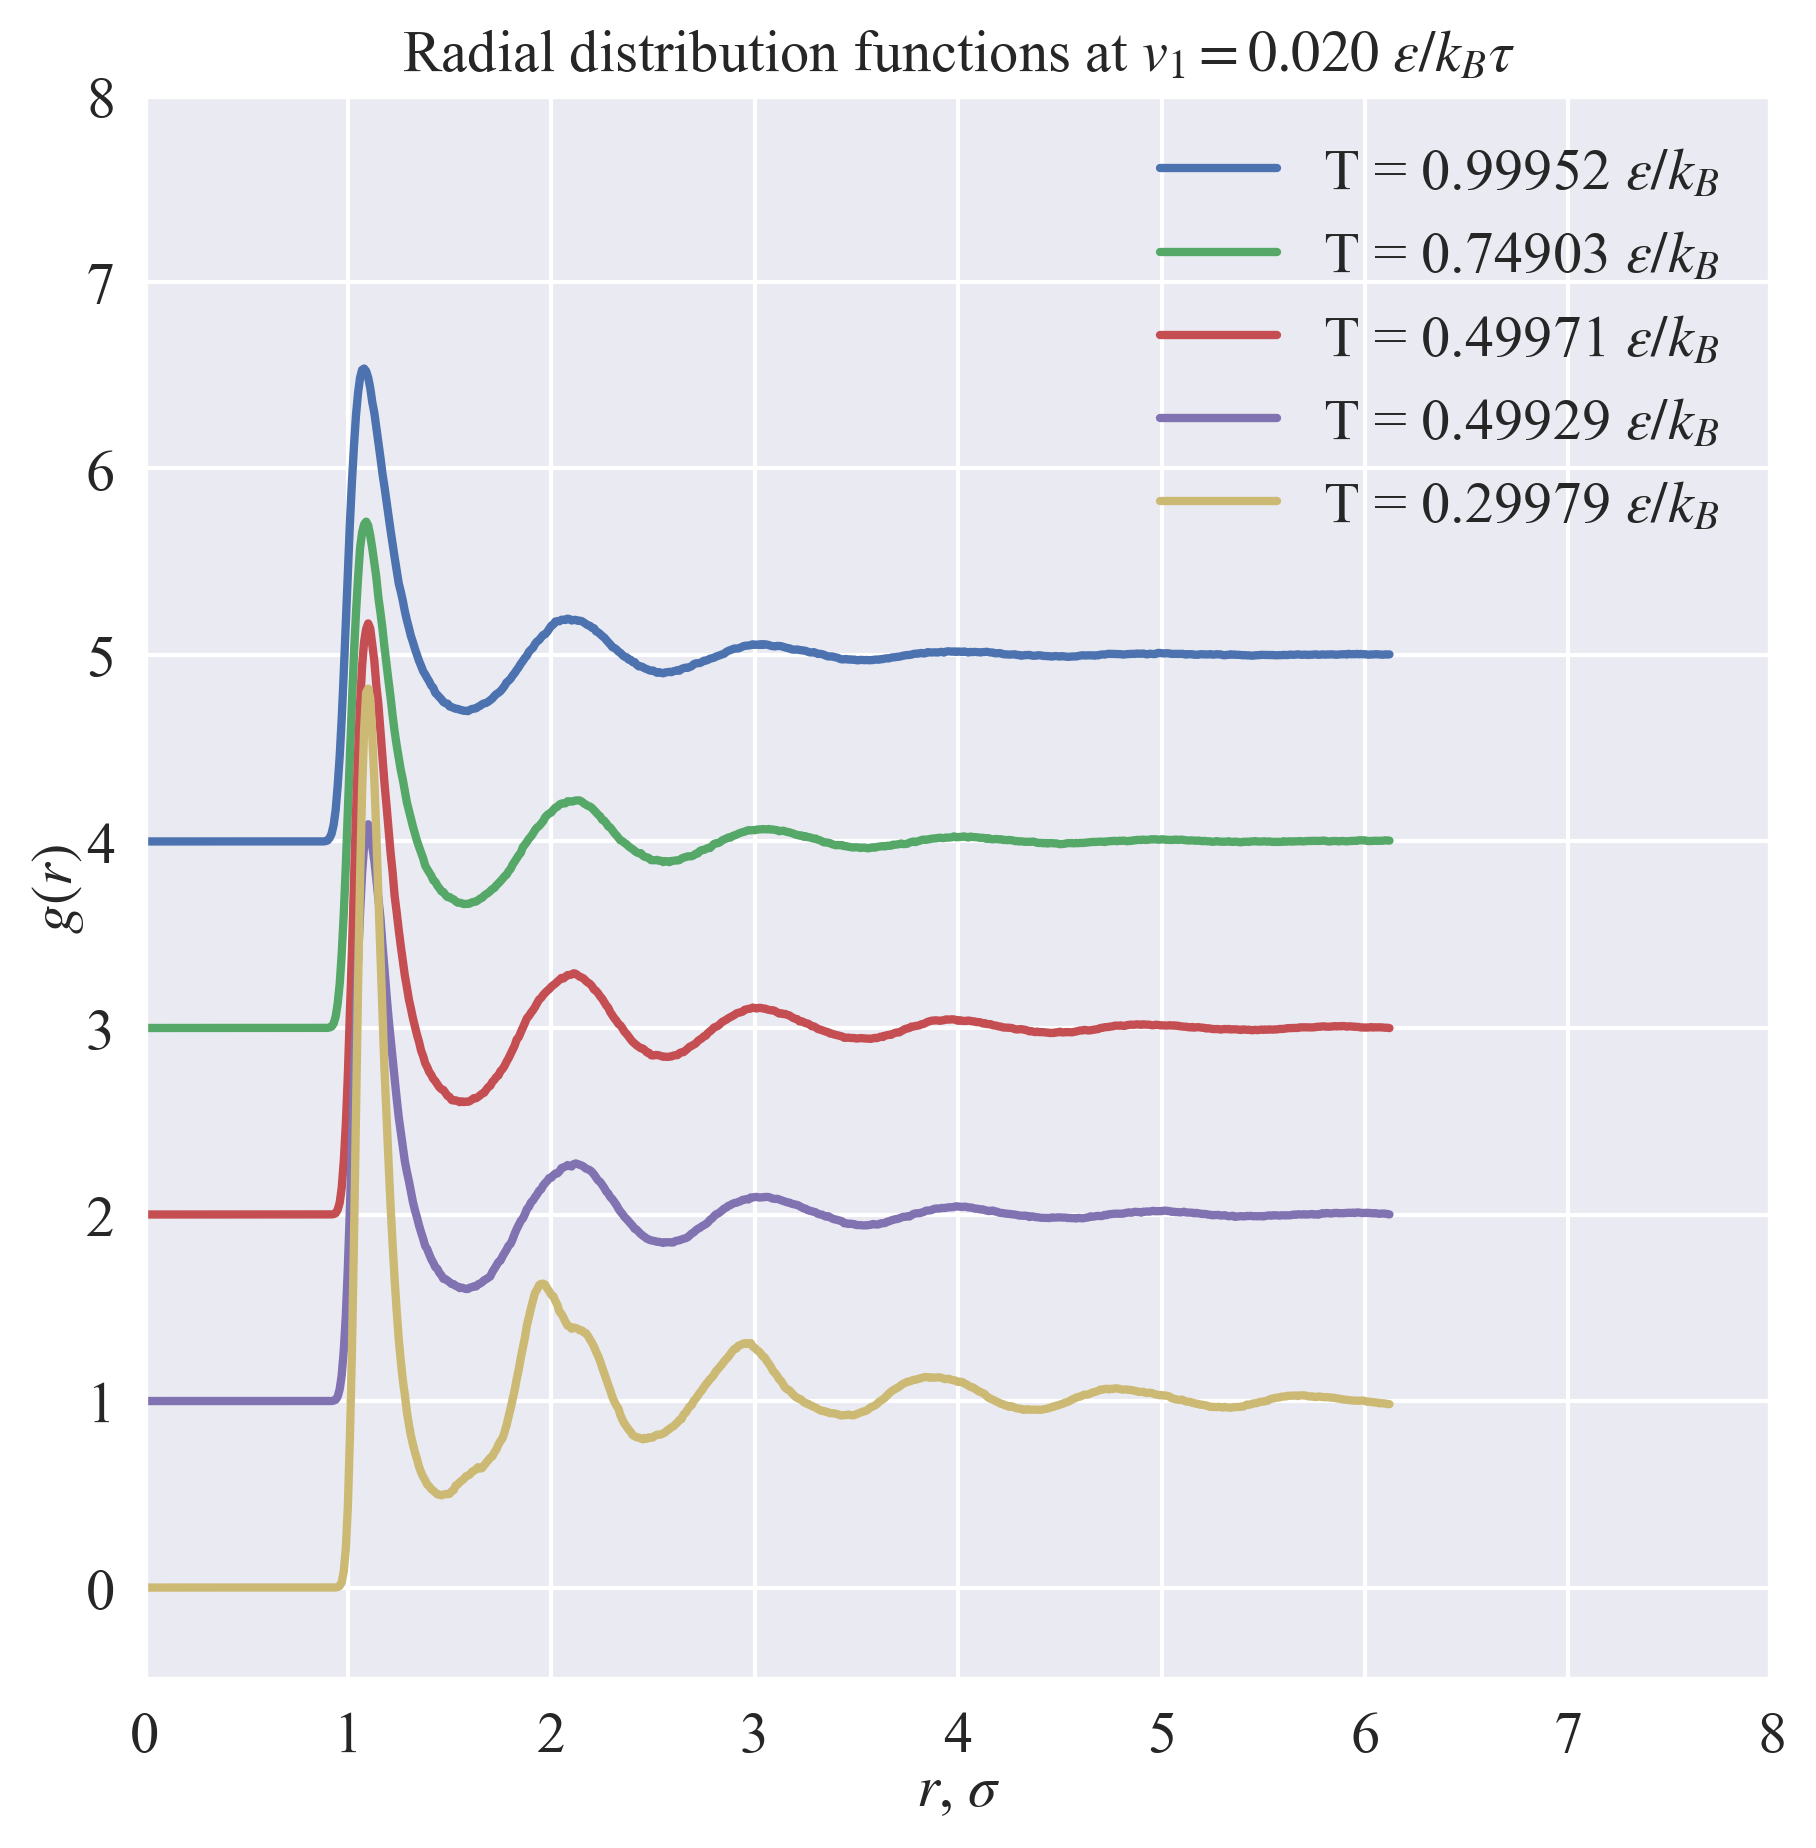

In [11]:
pp_normal.plot_rdf(
    shift=1.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=8,
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_1 = 0.020~\varepsilon / k_B\tau$',
    filename_postfix='full_size',
)

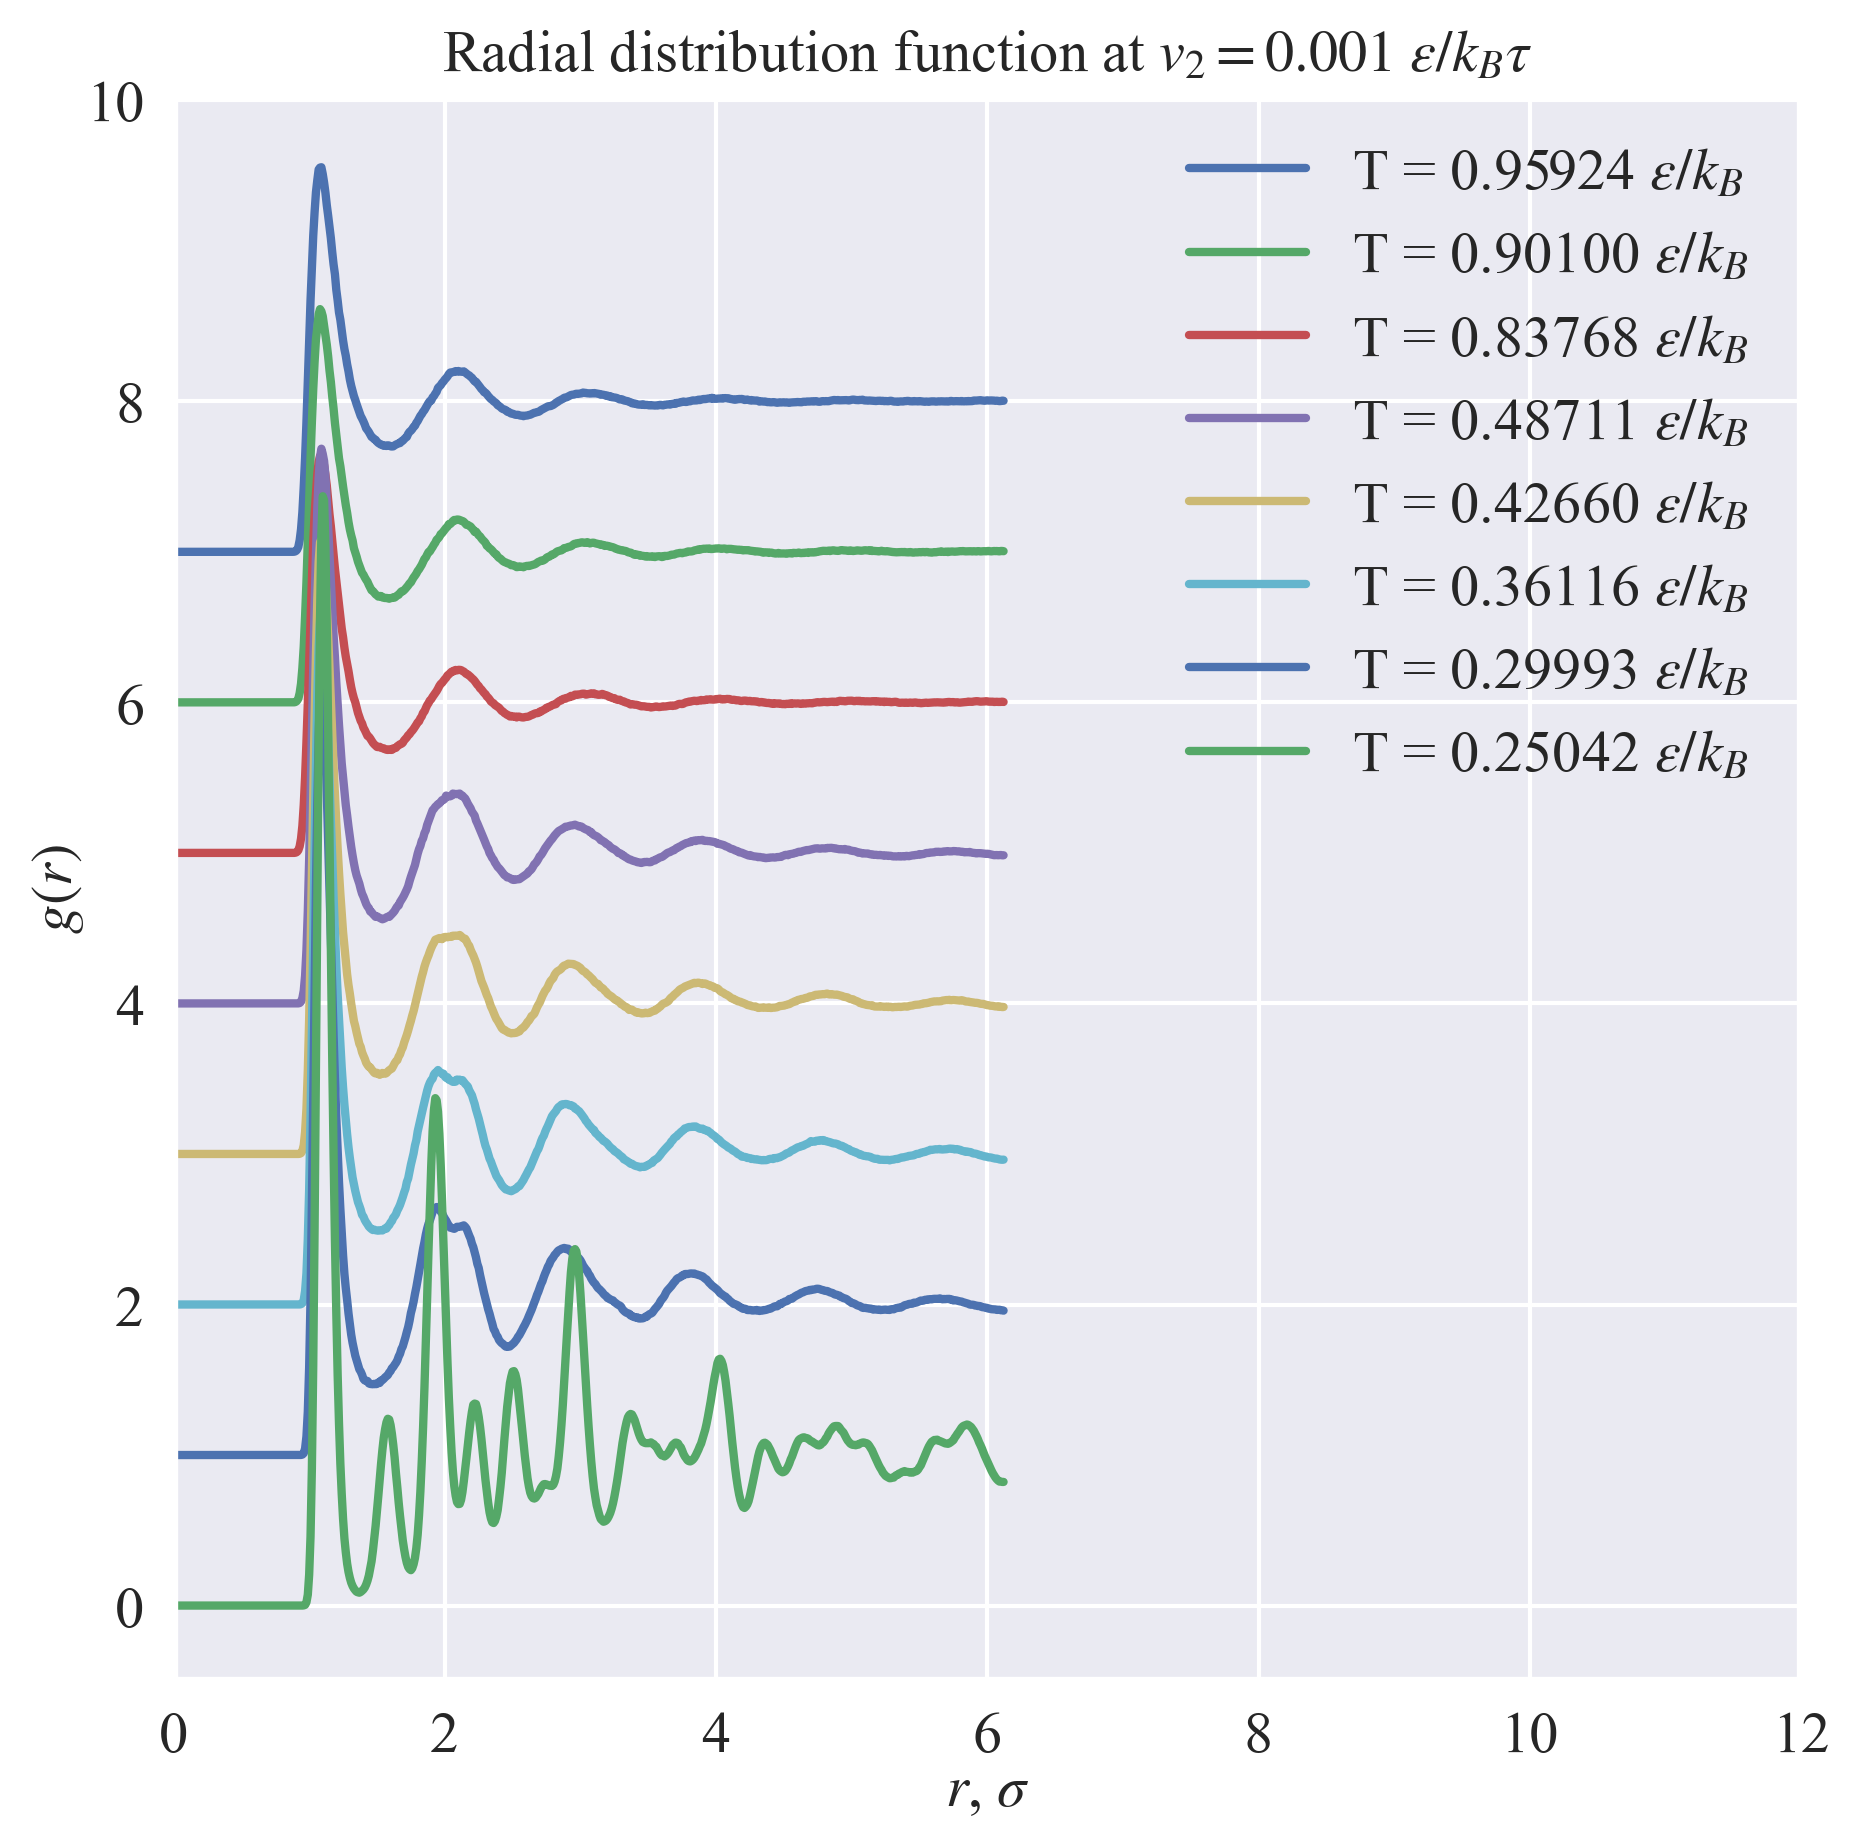

In [12]:
pp_slow.plot_rdf(
    shift=0.2,
    left=0,
    right=12,
    bottom=-0.5, 
#     top=14,
    figsize=FIGSIZE,
    title=r'Radial distribution function at $v_2 = 0.001~\varepsilon / k_B\tau$',
    filename_postfix='full_size',
    shown=[3, 8, 13, 18, 23, 28, 33, 38],
)

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [13]:
rr = RegressionRDF(
    post_processor=pp_slow, 
    setups=setups_slow,
    test_temperatures=test_temperatures,
)
rdf_table = rr.get_rdf_table()
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
setup_38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.898525,0.880614,0.865412,0.850921,0.839329,0.830279,0.823593,0.823287,0.821531,0.821260
setup_37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.911119,0.894532,0.876646,0.860637,0.847248,0.836915,0.830924,0.823148,0.817742,0.817683
setup_36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.908269,0.898463,0.891919,0.886642,0.881939,0.876962,0.873615,0.876363,0.877985,0.880437
setup_35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.962195,0.958203,0.956047,0.957306,0.957327,0.957964,0.957233,0.959026,0.961080,0.959863
setup_34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.991140,0.988795,0.989650,0.989373,0.985083,0.984181,0.984333,0.984272,0.983301,0.981287
setup_33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.968953,0.968081,0.967660,0.967144,0.964021,0.964659,0.965243,0.961900,0.961471,0.959317
setup_32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.966257,0.963670,0.963000,0.961690,0.960145,0.958630,0.958493,0.960664,0.960868,0.957021
setup_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.967720,0.967366,0.966723,0.962565,0.964474,0.962937,0.960175,0.960344,0.959261,0.957322
setup_30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.970318,0.968576,0.964147,0.961662,0.961123,0.963679,0.962245,0.962665,0.961257,0.960605
setup_29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.970194,0.967977,0.966078,0.962617,0.961159,0.963268,0.961804,0.963013,0.962563,0.962196


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм регрессии

In [17]:
is_printed=False
is_plotted=False

predicted_rdf_points = {key: [] for key in test_temperatures}

temperatures = np.array([
    setups_slow[value]['temperature']
    for value
    in rdf_table.index.str[6:].values.astype(np.int32)
])
x_train = temperatures.reshape((temperatures.size, 1))
test_temperatures = np.array(test_temperatures)
x_test = test_temperatures.reshape((test_temperatures.size, 1))

for column in rr.rdf_table.columns:
    y_train = rdf_table[column].values
#     regressor = KNeighborsRegressor(n_neighbors=10, weights='distance')
#     regressor = RadiusNeighborsRegressor(radius=5.0, weights='distance')
#     regressor = svm.SVR()
#     regressor = DecisionTreeRegressor()
    regressor = LinearRegression()
    regressor.fit(x_train, y_train)
    fitted_data = regressor.predict(x_test)
    for key, _ in predicted_rdf_points.items():
        predicted_rdf_points[key].append(fitted_data[np.where(test_temperatures == key)][0])

for key, value in predicted_rdf_points.items():
    predicted_rdf_points[key] = np.array(value)

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах (direct - посчитанные напрямую, predicted - предсказанные)

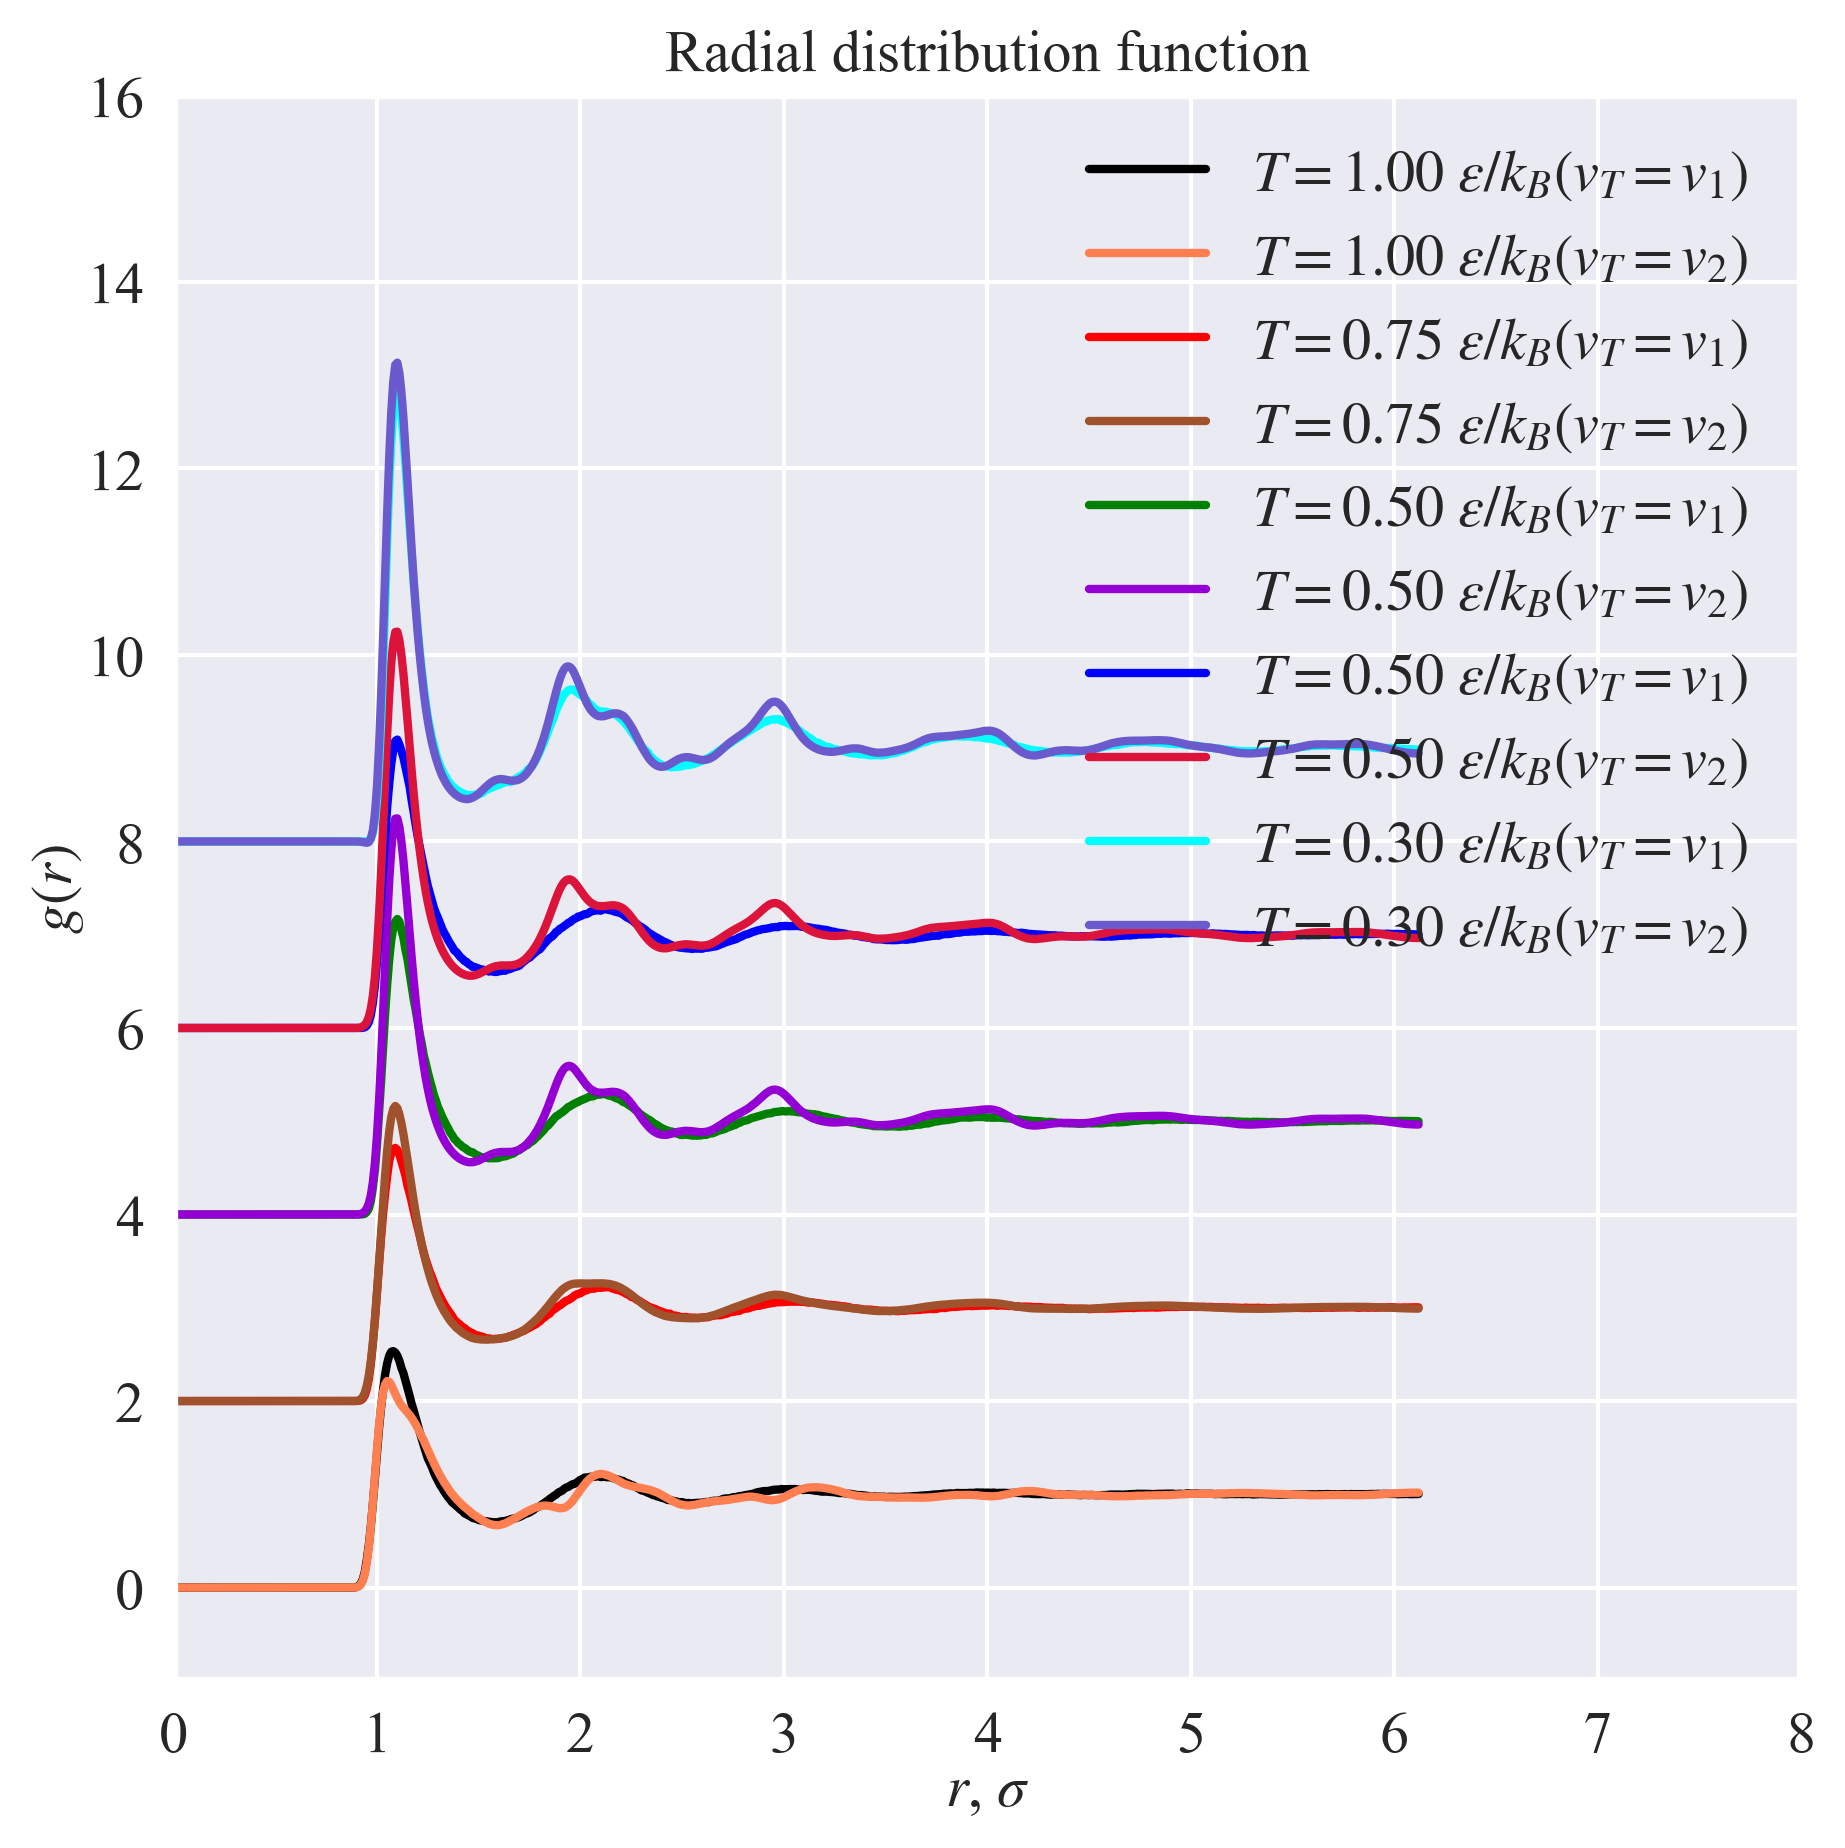

In [18]:
fig, ax = plt.subplots(figsize=FIGSIZE,)

for i, setup in enumerate(setups_normal):
    temperature = setup["temperature"]
    ax.plot(
        pp_normal.rdf.data['radius'],
        pp_normal.rdf.data[f'setup_{i}'] + i * 2,
        label=fr'$T = {temperature:.2f}~\epsilon / k_B (v_T=v_1)$',
        color=COLORS[i],
    );
    ax.plot(
        rdf_table.columns.values, 
        predicted_rdf_points[temperature] + i * 2,
        label=fr'$T = {temperature:.2f}~\epsilon / k_B (v_T=v_2)$',
        color=COLORS[-i-1],
    );
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-1, 
    top=16,
);
ax.set_title('Radial distribution function')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_cooling.png')

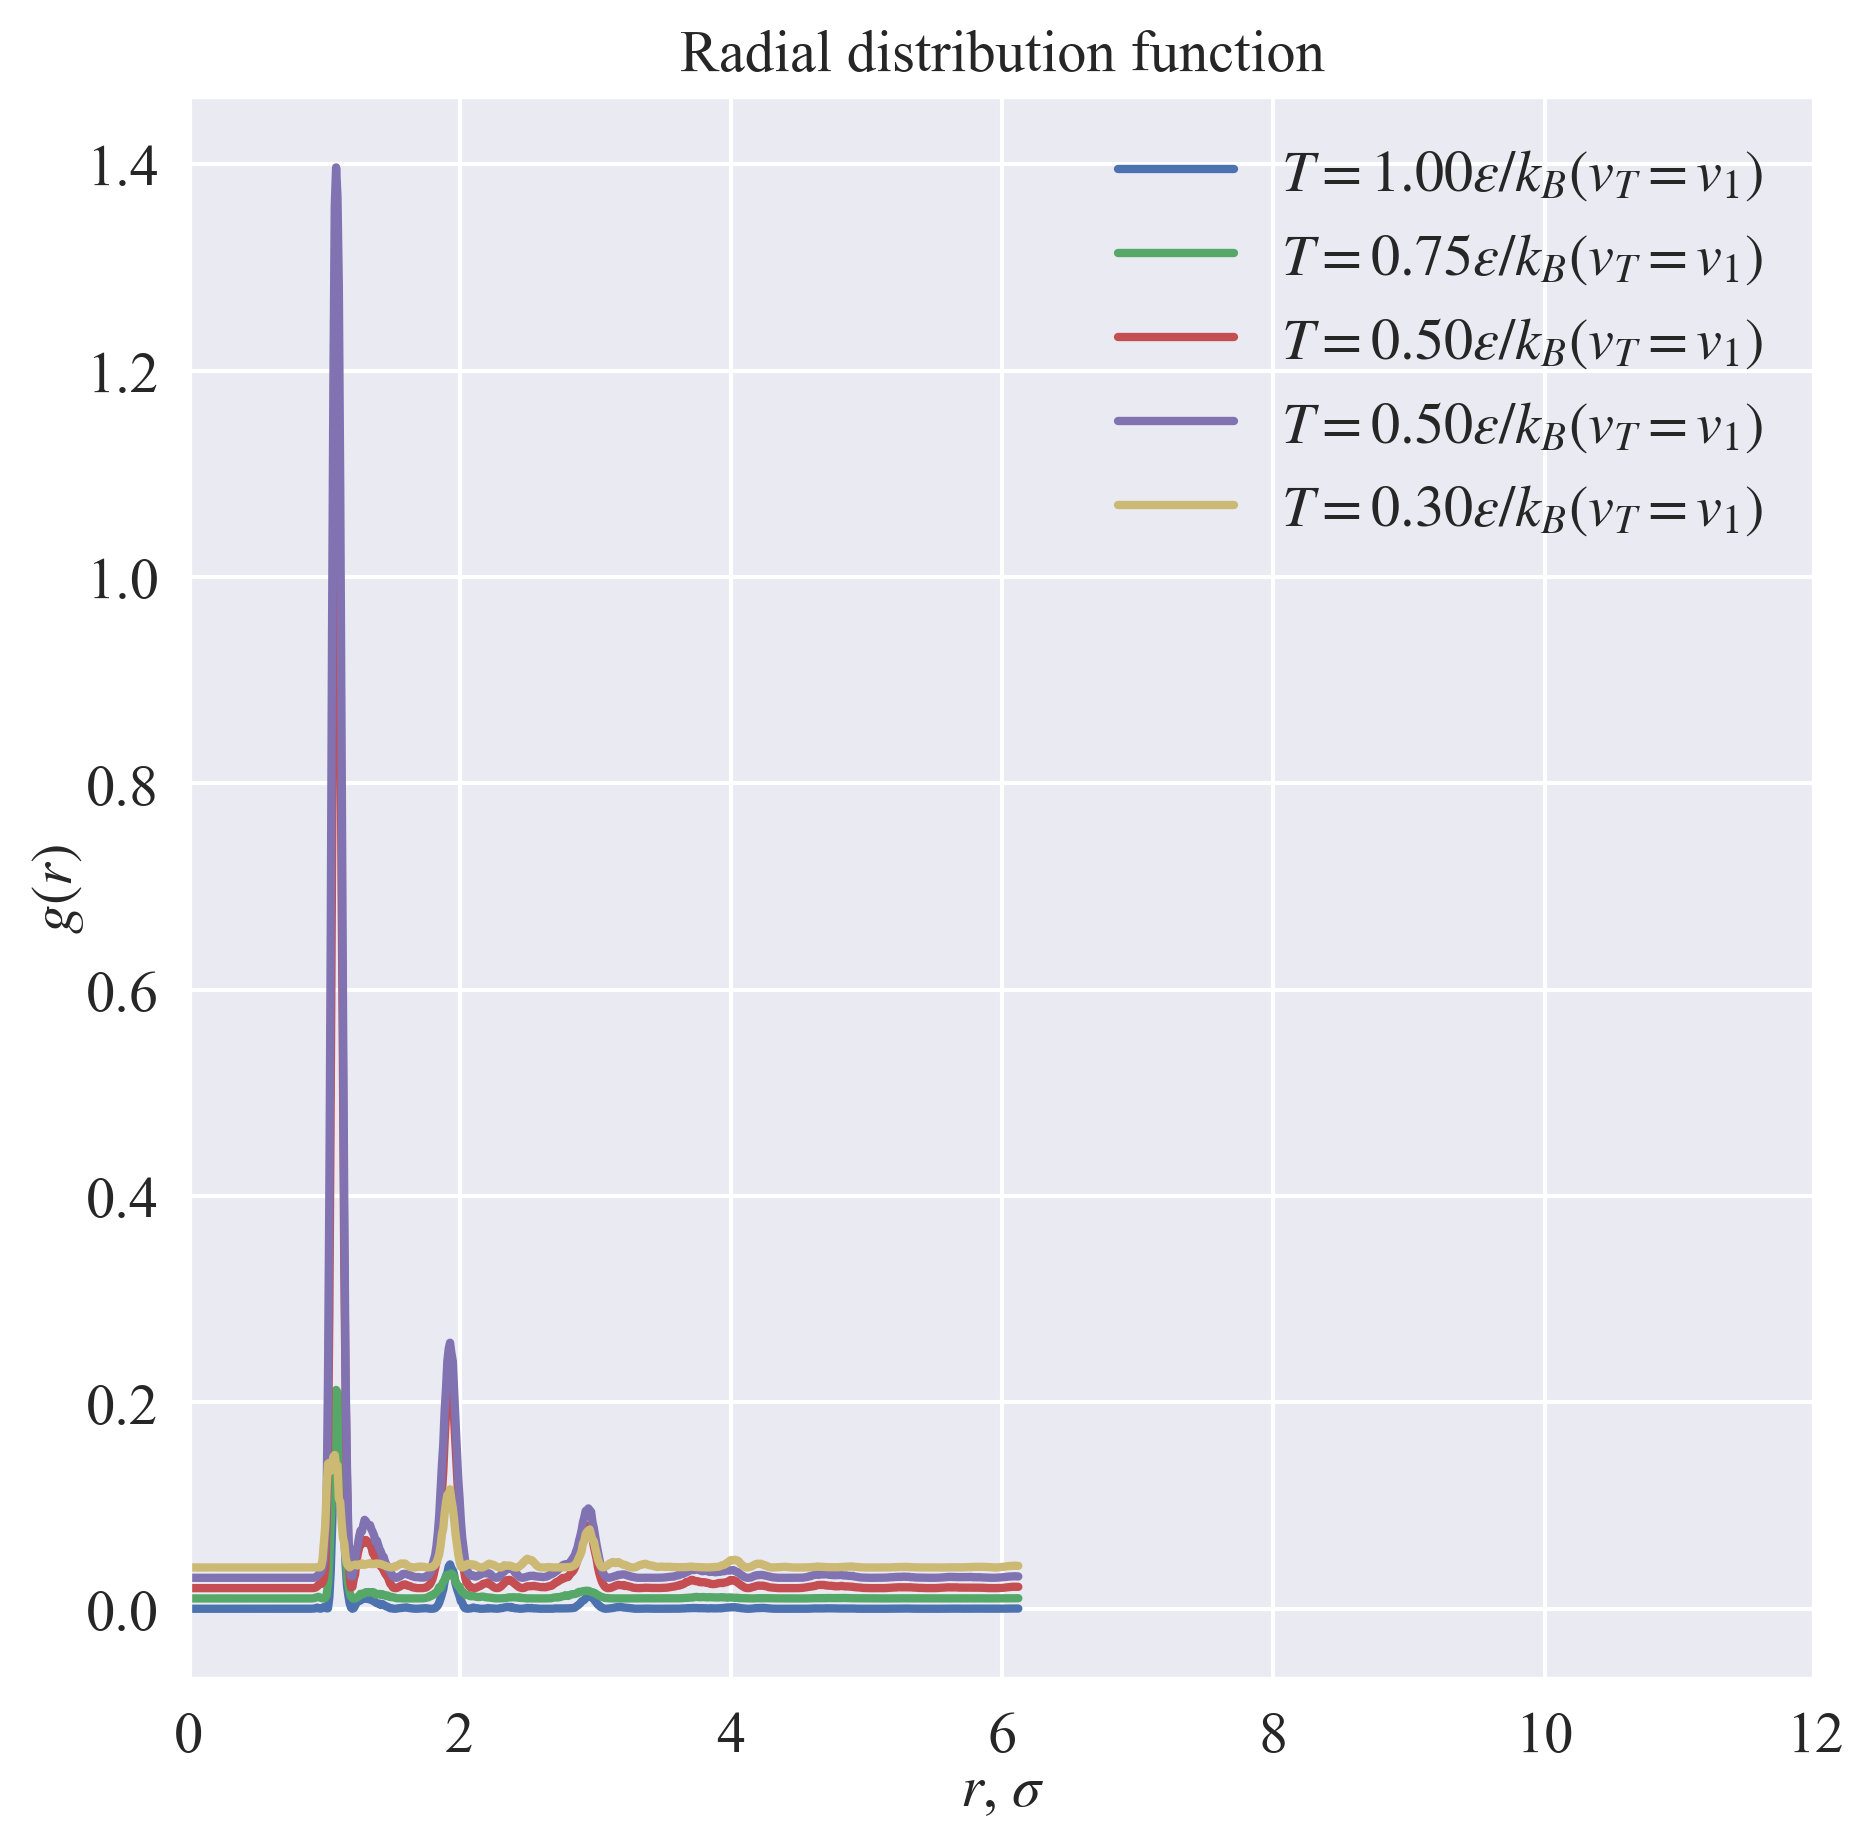

In [19]:
fig, ax = plt.subplots(figsize=FIGSIZE,)

for i, setup in enumerate(setups_normal):
    temperature = setup["temperature"]
    error = predicted_rdf_points[temperature] - pp_normal.rdf.data[f'setup_{i}']
    ax.plot(
        pp_normal.rdf.data['radius'],
        (error) ** 2 + i * 0.01,
        label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_1)$',
#         color=COLORS[i],
    );

ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=12,
);
ax.set_ylim(
#     bottom=-1, 
#     top=16,
);
ax.set_title('Radial distribution function')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_cooling.png')